# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

# Observed Trends

* The first major observable trend in the dataset for the cities generated by the uniform sampling across the full range of latitudes and longitudes for the global coordinate system is that the cities seem to be disproportionately distributed by hemisphere - that is, the northern hemisphere generally contains 65-70% of the cities i the dataset, with the remaining 30-35% located in the southern hemisphere. At first glance, this distribution seems uneven, until we take into account that most of the Earth's landmass is in the northern hemisphere, which includes approximately 71% of the world's landmass (see [here](https://www.quora.com/What-percentage-of-the-Earths-land-is-above-the-equator#:~:text=The%20total%20area%20of%20land,is%20north%20of%20the%20Equator)). This directly corresponds to the city distribution percentages by hemisphere, cofirming that the sampled cities are distributed relatively uniformly by latitude. One would expect a 50-50 split of cities based on surface area above and below the equator, but finding a different result leads us to question why there would be such a difference, and the answer appears to be the land mass percentage for each hemisphere, since cities are primarily built on land.


* Another trend observed is that the temperature tends to linearly increase towards the 20-degree latitude line across the northern and southern hemisphere, rather than reaching a peak at the equator. This can be accounted for by the axis tilt of the earth, which is approximately 23 degrees (see [here](https://earthobservatory.nasa.gov/features/Milankovitch/milankovitch_2.php#:~:text=Today%2C%20the%20Earth's%20axis%20is,between%2022.1%20and%2024.5%20degrees.)). The r-squared values of the best fit regression lines are about -0.7 and 0.8 for the northern and southern hemispheres when comparing temperature to latitude, and if the data were separated by the 23-degree latitude instead of the equator, those correlations would likely increase (especially for the northern hemisphere, since that plot includes some data before the peak temperature is reached, muddling the linear best fit). THese r-values suggest strong linear relationships between latitude and temperature for both the northern and southern hemispheres. The 23-degree latitude line represents the points on earth closest to the sun as the northern hemisphere experiences its summer, and we can expect the -23-degree latitude to show peak temperatures for the world during the northern hemisphere's winter and the southern hemisphere's summer.


* Finally, a trend observed from the VacationPy notebook is that the humidity values seem high across the world currently, represented by the numerous red-colored regions on the heatmap representing maximum or near-maximum humidity for the areas shown. The values seem especially high and continuous near coasts and some large bodies of water, like rivers or lakes, as compared to deeply inland areas of the continents. This is likely due to air having more evaporated water in it near the large bodies of water, which prevent the climate from becoming too arid. It would be interesting to use a statistic besides the relative humidity percentage that measures absolute humidity, like a measurement of water saturation in the air that is based on water mass per unit volume or some other absolute characteristic. The relative humidity changes based on the temperature, so air at higher temperatures can hold more water than air at lower temperatures, which would make an absolute measure of humidity show higher values for hot, wet areas like the tropics or rainforests as opposed to dryer or more temperate areas that still have a relatively high relative humidity. That might be a way to improve these notebooks for the next version, so that the humidity heat map give us further insights - but those calculations are currently out of the scope of this project.

In [4]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
import datetime

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [5]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

saved_lats = []
saved_longs = []

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    #also add estimated latitude and longitude
    if city not in cities:
        cities.append(city)
        saved_lats.append(lat_lng[0])
        saved_longs.append(lat_lng[1])
        
# print(citipy.nearest_city(0, 0).keys())

# Print the city count to confirm sufficient count
print("{} cities have been identified to poll for weather".format(len(cities)))

city_list = pd.DataFrame({"City":cities, "Approx. Latitude":saved_lats, "Approx. Longitude":saved_longs})
# city_list = pd.DataFrame({"City":cities})

#save to a csv (for reference - can compare estimated coordinates to actual coordinates if there is time, which cannot be done
#easily with citipy because the references only go one way -> approx. coordinates to city name, not city name to actual 
#coordinates)
city_list.to_csv("./CityNameList.csv")
city_list.head()

605 cities have been identified to poll for weather


,City,Approx. Latitude,Approx. Longitude
0,kloulklubed,3.222335,133.336777
1,rikitea,-54.497065,-112.746685
2,hami,39.870623,91.887579
3,terrace bay,48.853837,-88.185405
4,saldanha,-40.961281,-3.791138


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [6]:
#url for advanced mapping using OpenWeatherMap's new OneCall API to get historical weather info by coordinates instead of 
#city names - not implemented for project initially due to setup being different
# base_url = "https://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude={part}&appid={YOUR API KEY}"
# params = {"exclude":"minutely,hourly,current", "appid":weather_api_key, "lat":city_list["Latitude"][0], 
#           "lon":city_list["Longitude"][0]}

#setup columns for temperature, humidity, cloudiness, and wind speed
city_list["Max Temperature (F)"] = ""
city_list["Humidity (%)"] = ""
city_list["Cloudiness"] = ""
city_list["Wind Speed (mph)"] = ""

#setup columns for actual latitude and longitude
city_list["Actual Latitude"] = ""
city_list["Actual Longitude"] = ""

#setup column for country code
city_list["Country"] = ""

#setup column for city datetime
city_list["Datetime (Local)"] = ""
#note that current timezone is PST (-7:00 from GMT)
PST_offset = 7*60*60


base_url_current = "http://api.openweathermap.org/data/2.5/weather"
params = {"q":city_list["City"][0], "units":"imperial", "appid":weather_api_key}

test_response = requests.get(base_url_current, params)
json_response = test_response.json()
# json.dumps(json_response, indent=4)


#establish pattern for getting data into columns from json object
city_list["Actual Latitude"][0] = json_response["coord"]["lat"]
city_list["Actual Longitude"][0] = json_response["coord"]["lon"]
city_list["Max Temperature (F)"][0] = json_response["main"]["temp_max"]
city_list["Humidity (%)"][0] = json_response["main"]["humidity"]
city_list["Cloudiness"][0] = json_response["clouds"]["all"]
city_list["Wind Speed (mph)"][0] = json_response["wind"]["speed"]
city_list["Country"][0] = json_response["sys"]["country"]
#create datetime.datetime object to give local date and time at the city of interest (need to add an offset from our 
#computer clock set to PST and then add in the timezone shift given by the API to change from GMT)
first_city_time = datetime.datetime.fromtimestamp(json_response["dt"]+json_response["timezone"]+PST_offset)
city_list["Datetime (Local)"][0] = first_city_time.strftime("%m/%d/%Y, %H:%M:%S")

#create helper function to give the Datetime (UTC) column string
def getTimeString(resp_json, comp_time):
    curr_city_datetime = datetime.datetime.fromtimestamp(resp_json["dt"]+resp_json["timezone"]+comp_time)
    return curr_city_datetime.strftime("%m/%d/%Y, %H:%M:%S")

#create function to add all info to dataframe using the above pattern 
def addColumns(pd_df, resp_json, i, comp_time):
    pd_df["Actual Latitude"][i] = resp_json["coord"]["lat"]
    pd_df["Actual Longitude"][i] = resp_json["coord"]["lon"]
    pd_df["Max Temperature (F)"][i] = resp_json["main"]["temp_max"]
    pd_df["Humidity (%)"][i] = resp_json["main"]["humidity"]
    pd_df["Cloudiness"][i] = resp_json["clouds"]["all"]
    pd_df["Wind Speed (mph)"][i] = resp_json["wind"]["speed"]
    pd_df["Country"][i] = resp_json["sys"]["country"]
    #create datetime.datetime object to give local date and time at the city of interest (need to add an offset from our 
    #computer clock set to PST and then add in the timezone shift given by the API to change from GMT)
    #change it to a string to keep the timestamp the same in case it is examined later
    pd_df["Datetime (Local)"][i] = getTimeString(resp_json, comp_time)
        


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A valu

In [7]:
#loop over rows in dataframe to gather info for each city's weather
#put in its own cell to allow running separately from the test/setup of the API calls
record_count = len(city_list)

for i, row in city_list.iterrows():
    #use try/except construct to skip over missing cities or missing info
    try:
        params["q"] = row["City"]
        response = requests.get(base_url_current, params)
        json_resp = response.json()
        addColumns(city_list, json_resp, i, PST_offset)
        print("Retrieved record {} of {} for the city of {}".format(i+1, record_count, row["City"]))
    except:
        city_list["City"][i] = "Failed!!!"
        print("Could not retrieve record {} of {} for the city of {}".format(i+1, record_count, row["City"]))
        

city_list.head()

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A valu

Retrieved record 1 of 605 for the city of kloulklubed
Retrieved record 2 of 605 for the city of rikitea
Retrieved record 3 of 605 for the city of hami
Retrieved record 4 of 605 for the city of terrace bay
Retrieved record 5 of 605 for the city of saldanha
Retrieved record 6 of 605 for the city of knysna
Retrieved record 7 of 605 for the city of ubinskoye
Retrieved record 8 of 605 for the city of berlevag
Retrieved record 9 of 605 for the city of punta arenas
Retrieved record 10 of 605 for the city of vaini
Retrieved record 11 of 605 for the city of ushuaia
Retrieved record 12 of 605 for the city of beringovskiy
Retrieved record 13 of 605 for the city of butaritari
Retrieved record 14 of 605 for the city of merrill
Retrieved record 15 of 605 for the city of cherskiy
Retrieved record 16 of 605 for the city of cayenne
Retrieved record 17 of 605 for the city of barddhaman
Retrieved record 18 of 605 for the city of kapaa
Retrieved record 19 of 605 for the city of leningradskiy
Retrieved rec

C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Retrieved record 26 of 605 for the city of tiznit
Retrieved record 27 of 605 for the city of banjar
Retrieved record 28 of 605 for the city of hobart
Retrieved record 29 of 605 for the city of sao filipe
Retrieved record 30 of 605 for the city of lebu
Retrieved record 31 of 605 for the city of kostino
Retrieved record 32 of 605 for the city of eyl
Retrieved record 33 of 605 for the city of nome
Retrieved record 34 of 605 for the city of new norfolk
Retrieved record 35 of 605 for the city of praia
Retrieved record 36 of 605 for the city of qaanaaq
Retrieved record 37 of 605 for the city of basco
Retrieved record 38 of 605 for the city of alyangula
Retrieved record 39 of 605 for the city of hilo
Retrieved record 40 of 605 for the city of peniche
Retrieved record 41 of 605 for the city of georgetown
Could not retrieve record 42 of 605 for the city of kasra
Retrieved record 43 of 605 for the city of acapulco
Retrieved record 44 of 605 for the city of rio grande
Retrieved record 45 of 605 f

Retrieved record 178 of 605 for the city of margate
Retrieved record 179 of 605 for the city of malanje
Could not retrieve record 180 of 605 for the city of samalaeulu
Could not retrieve record 181 of 605 for the city of marcona
Retrieved record 182 of 605 for the city of batticaloa
Could not retrieve record 183 of 605 for the city of saleaula
Retrieved record 184 of 605 for the city of hithadhoo
Retrieved record 185 of 605 for the city of pevek
Could not retrieve record 186 of 605 for the city of vaitupu
Retrieved record 187 of 605 for the city of iralaya
Retrieved record 188 of 605 for the city of arman
Retrieved record 189 of 605 for the city of san cristobal
Retrieved record 190 of 605 for the city of te anau
Retrieved record 191 of 605 for the city of east london
Retrieved record 192 of 605 for the city of namatanai
Retrieved record 193 of 605 for the city of vintileasca
Retrieved record 194 of 605 for the city of copiapo
Retrieved record 195 of 605 for the city of port lincoln
Re

Retrieved record 331 of 605 for the city of panama city
Could not retrieve record 332 of 605 for the city of tumannyy
Retrieved record 333 of 605 for the city of ternate
Retrieved record 334 of 605 for the city of inverness
Retrieved record 335 of 605 for the city of kristianstad
Retrieved record 336 of 605 for the city of chokurdakh
Retrieved record 337 of 605 for the city of fredericksburg
Retrieved record 338 of 605 for the city of sassandra
Retrieved record 339 of 605 for the city of dudinka
Retrieved record 340 of 605 for the city of vanavara
Retrieved record 341 of 605 for the city of yulara
Retrieved record 342 of 605 for the city of weston-super-mare
Retrieved record 343 of 605 for the city of bilma
Retrieved record 344 of 605 for the city of santiago del estero
Retrieved record 345 of 605 for the city of narrabri
Retrieved record 346 of 605 for the city of lompoc
Retrieved record 347 of 605 for the city of koungou
Retrieved record 348 of 605 for the city of baykit
Retrieved re

Retrieved record 484 of 605 for the city of saint marys
Retrieved record 485 of 605 for the city of chapada dos guimaraes
Retrieved record 486 of 605 for the city of adrar
Retrieved record 487 of 605 for the city of faya
Could not retrieve record 488 of 605 for the city of palaiopirgos
Could not retrieve record 489 of 605 for the city of sorvag
Retrieved record 490 of 605 for the city of fare
Could not retrieve record 491 of 605 for the city of grand centre
Retrieved record 492 of 605 for the city of churapcha
Retrieved record 493 of 605 for the city of bandarbeyla
Retrieved record 494 of 605 for the city of pecos
Retrieved record 495 of 605 for the city of linxi
Retrieved record 496 of 605 for the city of naryan-mar
Retrieved record 497 of 605 for the city of zaysan
Retrieved record 498 of 605 for the city of fairbanks
Retrieved record 499 of 605 for the city of atambua
Retrieved record 500 of 605 for the city of ojinaga
Retrieved record 501 of 605 for the city of murgab
Retrieved rec

,City,Approx. Latitude,Approx. Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,kloulklubed,3.222335,133.336777,75.2,94,75,9.82,7.04,134.26,PW,"07/02/2020, 06:40:32"
1,rikitea,-54.497065,-112.746685,69.12,69,15,21.74,-23.12,-134.97,PF,"07/01/2020, 12:40:32"
2,hami,39.870623,91.887579,74.89,20,52,7.7,42.8,93.45,CN,"07/02/2020, 05:40:32"
3,terrace bay,48.853837,-88.185405,77,53,20,5.82,48.78,-87.1,CA,"07/01/2020, 17:40:33"
4,saldanha,-40.961281,-3.791138,53.6,87,0,3.36,-33.01,17.94,ZA,"07/01/2020, 23:40:33"


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [10]:
remaining_cities = city_list.loc[city_list["City"] != "Failed!!!"]
city_left_count = len(remaining_cities)
print("There is data for {} cities out of the {} cities identified, for a retrieval success rate of {:.1%}"
      .format(city_left_count, record_count, (city_left_count/record_count)))

remaining_cities.index = [a for a in range(city_left_count)]


#must change all the columns other than the three below to numeric types - 
#they are currently strings!
non_numeric_cols = ["City", "Country", "Datetime (Local)"]

for col in remaining_cities.columns:
    if(col not in non_numeric_cols):
        remaining_cities[col] = pd.to_numeric(remaining_cities[col])
        
remaining_cities.dtypes
remaining_cities

There is data for 553 cities out of the 605 cities identified, for a retrieval success rate of 91.4%


C:\Users\patri\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,City,Approx. Latitude,Approx. Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,kloulklubed,3.222335,133.336777,75.20,94,75,9.82,7.04,134.26,PW,"07/02/2020, 06:40:32"
1,rikitea,-54.497065,-112.746685,69.12,69,15,21.74,-23.12,-134.97,PF,"07/01/2020, 12:40:32"
2,hami,39.870623,91.887579,74.89,20,52,7.70,42.80,93.45,CN,"07/02/2020, 05:40:32"
3,terrace bay,48.853837,-88.185405,77.00,53,20,5.82,48.78,-87.10,CA,"07/01/2020, 17:40:33"
4,saldanha,-40.961281,-3.791138,53.60,87,0,3.36,-33.01,17.94,ZA,"07/01/2020, 23:40:33"
...,...,...,...,...,...,...,...,...,...,...,...
548,mayo,66.278308,-138.618830,78.80,78,75,6.93,38.89,-76.51,US,"07/01/2020, 17:42:35"
549,college,76.774835,-145.972672,62.01,38,75,3.36,64.86,-147.80,US,"07/01/2020, 13:41:32"
550,boyuibe,-20.328386,-62.402946,55.26,39,0,3.94,-20.42,-63.28,BO,"07/01/2020, 17:42:36"
551,praia da vitoria,44.480781,-22.654227,68.00,72,40,5.14,38.73,-27.07,PT,"07/01/2020, 21:42:36"


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [11]:
#check if there are any cities with >100% humidity
test_stats = remaining_cities["Humidity (%)"].describe(include = "all")
print("By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!")
test_stats

# remaining_cities["Humidity (%)"].value_counts()

By inspection, the maximum humidity value is 100%, so there are no values greater than 100% in our data!


count    553.000000
mean      70.084991
std       20.958162
min        3.000000
25%       58.000000
50%       75.000000
75%       85.000000
max      100.000000
Name: Humidity (%), dtype: float64

In [12]:
#  Get the indices of cities that have humidity over 100%.

In [13]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


In [14]:
# Extract relevant fields from the data frame


# Export the City_Data into a csv
remaining_cities.to_csv("../output_data/Retrieved_City_Weather_Data.csv")
remaining_cities

,City,Approx. Latitude,Approx. Longitude,Max Temperature (F),Humidity (%),Cloudiness,Wind Speed (mph),Actual Latitude,Actual Longitude,Country,Datetime (Local)
0,kloulklubed,3.222335,133.336777,75.20,94,75,9.82,7.04,134.26,PW,"07/02/2020, 06:40:32"
1,rikitea,-54.497065,-112.746685,69.12,69,15,21.74,-23.12,-134.97,PF,"07/01/2020, 12:40:32"
2,hami,39.870623,91.887579,74.89,20,52,7.70,42.80,93.45,CN,"07/02/2020, 05:40:32"
3,terrace bay,48.853837,-88.185405,77.00,53,20,5.82,48.78,-87.10,CA,"07/01/2020, 17:40:33"
4,saldanha,-40.961281,-3.791138,53.60,87,0,3.36,-33.01,17.94,ZA,"07/01/2020, 23:40:33"
...,...,...,...,...,...,...,...,...,...,...,...
548,mayo,66.278308,-138.618830,78.80,78,75,6.93,38.89,-76.51,US,"07/01/2020, 17:42:35"
549,college,76.774835,-145.972672,62.01,38,75,3.36,64.86,-147.80,US,"07/01/2020, 13:41:32"
550,boyuibe,-20.328386,-62.402946,55.26,39,0,3.94,-20.42,-63.28,BO,"07/01/2020, 17:42:36"
551,praia da vitoria,44.480781,-22.654227,68.00,72,40,5.14,38.73,-27.07,PT,"07/01/2020, 21:42:36"


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

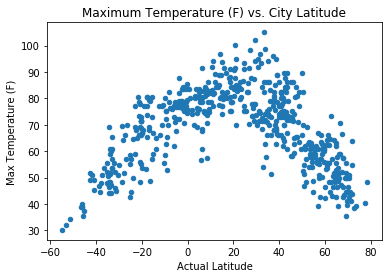

In [15]:
lat_vs_T_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Max Temperature (F)", 
                                      title="Maximum Temperature (F) vs. City Latitude")

lat_vs_T_axes.get_figure().savefig("../output_data/Temp_vs_Latitude_All_Cities.png")

The Temperature (F) vs. Latitude plot shown above, which includes data from all cities, peaks at approximately 20-degrees latitude. The latitude values below that latitude show a possible linear relationship with temperature, and the latitude values above that latitude also show a possible linear relationship with temperature, with both trends ending at the same peak temperature and latitude.

## Latitude vs. Humidity Plot

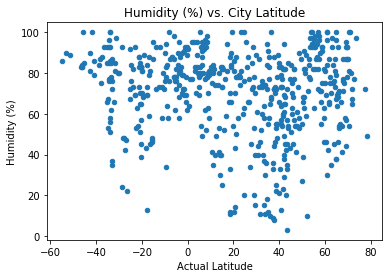

In [16]:
lat_vs_humidity_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Humidity (%)", 
                                      title="Humidity (%) vs. City Latitude")

lat_vs_humidity_axes.get_figure().savefig("../output_data/Humidity_vs_Latitude_All_Cities.png")

The Humidity vs. Latitude plot shown above, which contains data from all cities, shows a relatively spread-out distribution of data points. There does not appear to be a relationship between humidity and latitude at first glance, but the humidity percentages seem to largely cluster above 50%.

## Latitude vs. Cloudiness Plot

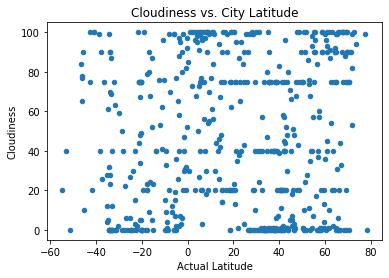

In [17]:
lat_vs_cloudiness_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Cloudiness", 
                                      title="Cloudiness vs. City Latitude")

lat_vs_cloudiness_axes.get_figure().savefig("../output_data/Cloudiness_vs_Latitude_All_Cities.png")

The Cloudiness vs. Latitude plot shown above, containing data from all cities, does not seem to show a relationship between cloudiness and city latitude. There seem to be some values for cloudiness that the points cluster along, noticeably 0, 20, 40, 75, 90, and 100, so those values may be rounded or categorized from some of the sources, and not represent continuous variables or measurements.

## Latitude vs. Wind Speed Plot

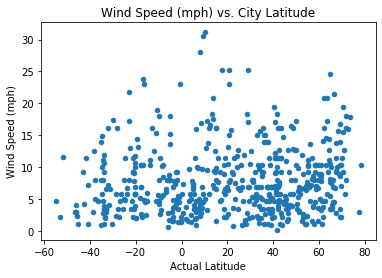

In [18]:
lat_vs_wind_speed_axes = remaining_cities.plot(kind="scatter", x="Actual Latitude", y="Wind Speed (mph)", 
                                      title="Wind Speed (mph) vs. City Latitude")

lat_vs_wind_speed_axes.get_figure().savefig("../output_data/Wind_Speed_vs_Latitude_All_Cities.png")

The Wind speed vs. Latitude plot, shown above for all cities, does not seem to show any relationship between wind speed and latitude. Most of the wind speed values are below about 25 mph, with only a few values above that wind speed limit.

## Linear Regression

In [19]:
# OPTIONAL: Create a function to create Linear Regression plots

#takes in as arguments a DataFrame (df), the x-axis String column name (x_Col), and the y-axis String column name (y_Col)
#plots a scatter plot with the df[x_Col] on the x-axis and the df[y_Col] data on the y-axis, and the linear regression line
#prints information about the best fit line from the linear regression
#returns the axes object for the plot, so more changes can be made later if necessary
def makeLinRegression(df, x_Col, y_Col):
    #first, perform the linear regression on the data
    (regr_slope, regr_intercept, regr_r_val, _, _) = linregress(df[x_Col], 
                                                           df[y_Col])
    #setup the linear regression line x and y axes data points
    regr_line_x = np.array([a for a in range(int(min(df[x_Col].values)), int(max(df[x_Col].values)+1))])
    regr_line_y = regr_slope * regr_line_x + regr_intercept

    #plot the scatterplot with the raw data first!
    df_axes = df.plot(kind="scatter", x=x_Col, y=y_Col, 
                      title="{} vs. {} ({})"
                        .format(y_Col, x_Col, remaining_cities["Datetime (Local)"].iloc[0].split(",")[0]))

    #add the best fit lines to the plot as a solid red line
    df_axes.plot(regr_line_x, regr_line_y, 'r')

    #output best-fit line information
    print("The equation of the best-fit linear regression line for this chart is y={:.2f}x+{:.2f}"
          .format(regr_slope, regr_intercept))
    print("The r-squared correlation coefficient for this line is {:.2f}".format(regr_r_val))
                  
    #return the axes object for the plots, in case any changes need to be made
    return df_axes

In [20]:
# Create Northern and Southern Hemisphere DataFrames

#first, get a subset of all the cities that are on or north of the equator for the Northern Hemisphere DataFrame
northern_hemisphere = remaining_cities.loc[remaining_cities["Actual Latitude"] >= 0]
northern_cities_count = len(northern_hemisphere)
print("There are {} cities in the northern hemisphere out of {} cities total, representing {:.1%} of all cities in the data set."
     .format(northern_cities_count, city_left_count, (northern_cities_count/city_left_count)))

#first, get a subset of all the cities that are south of the equator for the Southern Hemisphere DataFrame
southern_hemisphere = remaining_cities.loc[remaining_cities["Actual Latitude"] < 0]
southern_cities_count = len(southern_hemisphere)
print("There are {} cities in the southern hemisphere out of {} cities total, representing {:.1%} of all cities in the data set."
     .format(southern_cities_count, city_left_count, (southern_cities_count/city_left_count)))


There are 388 cities in the northern hemisphere out of 553 cities total, representing 70.2% of all cities in the data set.
There are 165 cities in the southern hemisphere out of 553 cities total, representing 29.8% of all cities in the data set.


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=-0.52x+90.49
The r-squared correlation coefficient for this line is -0.72


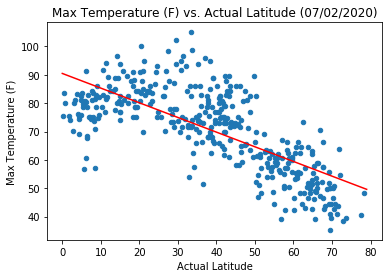

In [21]:
(n_temp_slope, n_temp_intercept, n_temp_r_val, _, _) = linregress(northern_hemisphere["Actual Latitude"], 
                                                           northern_hemisphere["Max Temperature (F)"])

regr_line_x = np.array([a for a in range(80)])
regr_line_y = n_temp_slope * regr_line_x + n_temp_intercept

n_temp_axes = northern_hemisphere.plot(kind="scatter", x="Actual Latitude", 
                                       y="Max Temperature (F)", 
                                       title="Max Temperature (F) vs. Actual Latitude ({})".
                                       format(remaining_cities["Datetime (Local)"].iloc[0].split(",")[0]))
                        

n_temp_axes.plot(regr_line_x, regr_line_y, 'r')

print("The equation of the best-fit linear regression line for this chart is y={:.2f}x+{:.2f}"
      .format(n_temp_slope, n_temp_intercept))
print("The r-squared correlation coefficient for this line is {:.2f}".format(n_temp_r_val))
n_temp_axes.get_figure().savefig("../output_data/Temp_vs_Latitude_N_Hemisphere.png")

The Max Temperature vs. Latitude plot for cities in the northern hemisphere is shown above. The max temperature appears show a strong negative linear relationship with latitudes in the northern hemisphere, with an r-value of -0.72 for the linear best-fit regression line.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=0.83x+81.01
The r-squared correlation coefficient for this line is 0.84


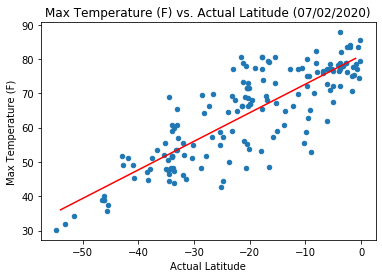

In [22]:
s_temp_lat_axes = makeLinRegression(southern_hemisphere, "Actual Latitude", "Max Temperature (F)")
s_temp_lat_axes.get_figure().savefig("../output_data/Temp_vs_Latitude_S_Hemisphere.png")

The Max Temperature vs. Latitude plot for cities in the southern hemisphere is shown above. The max temperature appears show a strong positive linear relationship with latitudes in the southern hemisphere, with an r-value of 0.84 for the linear best-fit regression line.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=0.03x+66.74
The r-squared correlation coefficient for this line is 0.03


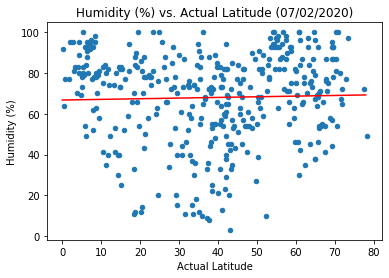

In [23]:
n_humidity_lat_axes = makeLinRegression(northern_hemisphere, "Actual Latitude", "Humidity (%)")
n_humidity_lat_axes.get_figure().savefig("../output_data/Humidity_vs_Latitude_N_Hemisphere.png")

The Humidity vs. Latitude plot for cities in the northern hemisphere is shown above. The data seems to show no relationship between the humidity and latitude for the northern hemisphere.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=-0.06x+73.82
The r-squared correlation coefficient for this line is -0.05


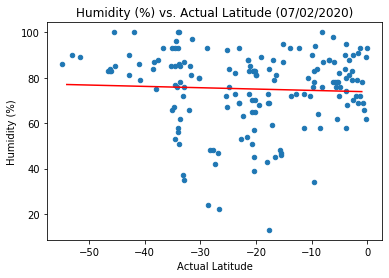

In [24]:
s_humidity_lat_axes = makeLinRegression(southern_hemisphere, "Actual Latitude", "Humidity (%)")
s_humidity_lat_axes.get_figure().savefig("../output_data/Humidity_vs_Latitude_S_Hemisphere.png")

The Humidity vs. Latitude plot for cities in the southern hemisphere is shown above. The data seems to show no relationship between the humidity and latitude for the southern hemisphere.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=-0.14x+54.04
The r-squared correlation coefficient for this line is -0.08


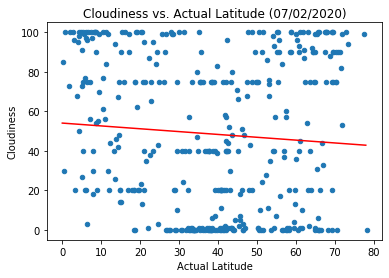

In [25]:
n_cloudiness_lat_axes = makeLinRegression(northern_hemisphere, "Actual Latitude", "Cloudiness")
n_cloudiness_lat_axes.get_figure().savefig("../output_data/Cloudiness_vs_Latitude_N_Hemisphere.png")

The Cloudiness vs. Latitude plot for cities in the northern hemisphere is shown above. The data seems to show no relationship between cloudiness and latitude for the northern hemisphere.

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=-0.00x+38.82
The r-squared correlation coefficient for this line is -0.00


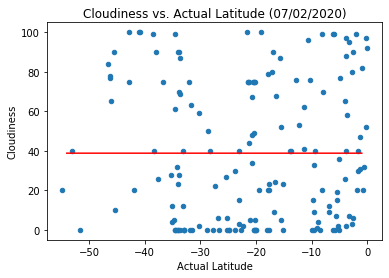

In [27]:
s_cloudiness_lat_axes = makeLinRegression(southern_hemisphere, "Actual Latitude", "Cloudiness")
s_cloudiness_lat_axes.get_figure().savefig("../output_data/Cloudiness_vs_Latitude_S_Hemisphere.png")

The Cloudiness vs. Latitude plot for cities in the southern hemisphere is shown above. The data seems to show no relationship between cloudiness and latitude for the southern hemisphere.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=0.01x+7.61
The r-squared correlation coefficient for this line is 0.04


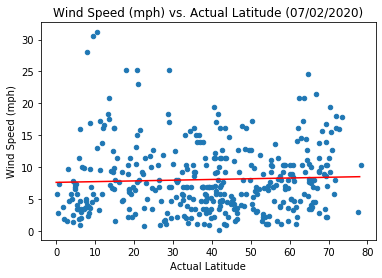

In [28]:
n_wind_lat_axes = makeLinRegression(northern_hemisphere, "Actual Latitude", "Wind Speed (mph)")
n_wind_lat_axes.get_figure().savefig("../output_data/Wind_Speed_vs_Latitude_N_Hemisphere.png")

The Wind Speed vs. Latitude plot for cities in the northern hemisphere is shown above. The data seems to show no relationship between wind speed and latitude for the northern hemisphere.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The equation of the best-fit linear regression line for this chart is y=0.03x+7.67
The r-squared correlation coefficient for this line is 0.08


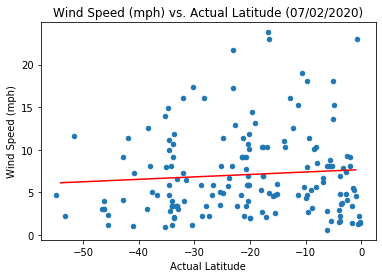

In [29]:
s_wind_lat_axes=makeLinRegression(southern_hemisphere, "Actual Latitude", "Wind Speed (mph)")
s_wind_lat_axes.get_figure().savefig("../output_data/Wind_Speed_vs_Latitude_S_Hemisphere.png")

The Wind Speed vs. Latitude plot for cities in the southern hemisphere is shown above. The data seems to show no relationship between wind speed and latitude for the southern hemisphere.